# Oil and Gas Production and Emissions Data on the Norwegian Continental Shelf

## Part 4

This is the fourth part of a series of notebooks that I am creating to analyze the oil and gas production and emissions data on the Norwegian Continental Shelf. The data is provided by the Norwegian Petroleum Directorate (NPD) and covers the period from 2001 to 2020. The data is available on the NPD website and can be downloaded from the following link: [Production and Emissions Data](https://factpages.sodir.no/).

You can find the other parts of the series here:

#### Part 1: [Data Collection](https://github.com/percw/Norwegian_oil_gas_decarbonization/blob/main/notebooks/01_data_building/01_production_and_emission_data_building.ipynb)

#### Part 2: [Data Cleaning](https://github.com/percw/Norwegian_oil_gas_decarbonization/blob/main/notebooks/02_data_cleaning/02_production_and_emission_data_cleaning.ipynb)

#### Part 3 [Data Processing](https://github.com/percw/Norwegian_oil_gas_decarbonization/blob/main/notebooks/03_data_processing/03_production_and_emission_data_processing.ipynb)

#### Part 5 [Data Optimization](https://github.com/percw/Norwegian_oil_gas_decarbonization/blob/main/notebooks/05_data_optimization/05_data_optimization.ipynb)


# Table of contents


## Imports


In [33]:
# Required Libraries
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from doubleml import DoubleMLData, DoubleMLPLR
from doubleml.datasets import fetch_bonus
from linearmodels.panel import PanelOLS
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBRegressor

pd.set_option("display.max_columns", None)


# Define a function for calculating root mean squared error
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [34]:
# Importing the dataset from the csv file
filepath = "https://raw.githubusercontent.com/percw/Norwegian_oil_gas_decarbonization/main/data/output/emissions_and_production/cleaned/fields_prod_emissions_intensities_share_1997_2023.csv"

# Creating a check if import is successful
try:
    data = pd.read_csv(filepath, sep=",")
    print("Data import successful")
except:
    print("Data import failed")

Data import successful


## Estimating Electrification Effect Using TWFE

We want to check how electrification of the oil and gas platforms in the Norwegian Continental Shelf has affected emissions. We will use a Two Way Fixed Effects model to estimate the effect of electrification on emissions.


In [35]:
data.head(5)

,field,year,net_oil_prod_yearly_mill_sm3,net_gas_prod_yearly_bill_sm3,net_ngl_prod_yearly_mill_sm3,net_condensate_prod_yearly_mill_sm3,net_oil_eq_prod_yearly_mill_sm3,produced_water_yearly_mill_sm3,field_id,net_oil_prod_monthly_sm3_volatility,net_gas_prod_monthly_sm3_volatility,net_ngl_prod_monthly_sm3_volatility,net_condensate_prod_monthly_sm3_volatility,net_oil_eq_prod_monthly_sm3_volatility,produced_water_in_field_volatility,status,current_status,field_owner,processing_field,field_in_emissions,facilities_lifetime_mean,facilities_lifetime_std,facilities_water_depth_mean,facilities_water_depth_std,subsea_facilites_shut_down,surface_facilites_shut_down,subsea_facilites_in_service,surface_facilites_in_service,facility_kind_multi well template,facility_kind_single well template,facility_kind_offshore wind turbine,facility_kind_subsea structure,facility_kind_fpso,facility_kind_jacket 8 legs,facility_kind_condeep monoshaft,facility_kind_loading system,facility_kind_jacket 4 legs,facility_kind_jacket tripod,facility_kind_fsu,facility_kind_semisub steel,facility_kind_condeep 4 shafts,facility_kind_landfall,facility_kind_tlp concrete,facility_kind_jack-up 3 legs,facility_kind_jacket 6 legs,facility_kind_tlp steel,facility_kind_semisub concrete,facility_kind_mopustor,facility_kind_spar,well_status_closed,well_status_drilling,well_status_injecting,well_status_junked,well_status_online/operational,well_status_p&a,well_status_plugged,well_status_producing,well_status_suspended,well_purpose_injection,well_purpose_observation,well_purpose_production,well_subsea_no,well_subsea_yes,well_final_vertical_depth_mean,well_final_vertical_depth_std,well_water_depth_mean,well_water_depth_std,investments_mill_nok,future_investments_mill_nok,yearly_co2_emissions_1000_tonnes,org_number,operator,yearly_ch4_emissions_tons,yearly_nox_emissions_tons,yearly_oil_spill_emissions_tons,yearly_water_emissions_m3,ownership_original,ownership_new_name,current_remaining_recoverable_oil,current_remaining_recoverable_gas,current_remaining_recoverable_ngl,current_remaining_recoverable_condensate,current_remaining_recoverable_oe,original_recoverable_oil,original_recoverable_gas,original_recoverable_ngl,original_recoverable_condensate,original_recoverable_oe,electrified,years_electrified,electricity_mw,imported_power_2023_gwh/y,year_electrified,yearly_tco2e_gwp100,yearly_tco2e_gwp20,kgco2e/toe_int_gwp100,share_peak_prod,oe_cum_sum_prod,share_reserve_of_original_reserve,oe_fac_prod_mill_sm3,yearly_fac_tco2e_gwp100,oe_share_prod,yearly_tco2e_prod_share_emissions,share_intensity_tco2e/toe_gwp100,gas_reserve_ratio,oil_reserve_ratio,oil_gas_reserve_ratio
0,statfjord nord,1997,3.93531,0.17288,0.09230,0.00000,4.20051,0.0,43679,0.053898,0.000405,0.000334,0.000000,0.054005,0.0,Producing,Producing,21084.0,statfjord,True,27.5,15.000000,241.75,65.030121,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,6.0,9.0,0.0,4.0,0.0,13.0,0.0,17.0,2888.800000,0.000000,285.000000,0.000000,255.0,2946.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'Den norske stats oljeselskap a.s': 50.0, 'Mo...","{'Equinor ASA': 1.875, 'Mobil Development Norw...",3.72,0.23,0.05,0.0,4.05,44.12,2.37,1.12,0.00,48.62,0,0,0,0.0,NaN,NaN,NaN,0.000000,100.00000,4.20051,91.360531,32.43504,1.784085e+06,0.129505,231048.521058,65.481992,0.000049,0.907445,18.616034
1,veslefrikk,1997,3.47468,0.13919,0.08596,0.00000,3.69981,0.0,43618,0.052851,0.008952,0.005461,0.000000,0.053418,0.0,Producing,Shut down,21212.0,veslefrikk,True,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,111.0,0.0,0.0,69.0,6.0,36.0,111.0,0.0,3317.000000,0.000000,175.000000,0.000000,229.0,0.0,156.20492,993246905.0,equinor energy as,64.319881,973.46610,88.599389,2782760.0,"{'Den norske stats oljeselskap a.s': 55.0, 'To...","{'Equinor ASA': 55.0, 'TotalEnergies EP Norge'...",0.00,0.00,0.00,0.0,0.00,55.34,4.19,1.81

In [145]:
data[data["field"] == "troll"]

,field,year,net_oil_prod_yearly_mill_sm3,net_gas_prod_yearly_bill_sm3,net_ngl_prod_yearly_mill_sm3,net_condensate_prod_yearly_mill_sm3,net_oil_eq_prod_yearly_mill_sm3,produced_water_yearly_mill_sm3,field_id,net_oil_prod_monthly_sm3_volatility,net_gas_prod_monthly_sm3_volatility,net_ngl_prod_monthly_sm3_volatility,net_condensate_prod_monthly_sm3_volatility,net_oil_eq_prod_monthly_sm3_volatility,produced_water_in_field_volatility,status,current_status,field_owner,processing_field,field_in_emissions,facilities_lifetime_mean,facilities_lifetime_std,facilities_water_depth_mean,facilities_water_depth_std,subsea_facilites_shut_down,surface_facilites_shut_down,subsea_facilites_in_service,surface_facilites_in_service,facility_kind_multi well template,facility_kind_single well template,facility_kind_offshore wind turbine,facility_kind_subsea structure,facility_kind_fpso,facility_kind_jacket 8 legs,facility_kind_condeep monoshaft,facility_kind_loading system,facility_kind_jacket 4 legs,facility_kind_jacket tripod,facility_kind_fsu,facility_kind_semisub steel,facility_kind_condeep 4 shafts,facility_kind_landfall,facility_kind_tlp concrete,facility_kind_jack-up 3 legs,facility_kind_jacket 6 legs,facility_kind_tlp steel,facility_kind_semisub concrete,facility_kind_mopustor,facility_kind_spar,well_status_closed,well_status_drilling,well_status_injecting,well_status_junked,well_status_online/operational,well_status_p&a,well_status_plugged,well_status_producing,well_status_suspended,well_purpose_injection,well_purpose_observation,well_purpose_production,well_subsea_no,well_subsea_yes,well_final_vertical_depth_mean,well_final_vertical_depth_std,well_water_depth_mean,well_water_depth_std,investments_mill_nok,future_investments_mill_nok,yearly_co2_emissions_1000_tonnes,org_number,operator,yearly_ch4_emissions_tons,yearly_nox_emissions_tons,yearly_oil_spill_emissions_tons,yearly_water_emissions_m3,ownership_original,ownership_new_name,current_remaining_recoverable_oil,current_remaining_recoverable_gas,current_remaining_recoverable_ngl,current_remaining_recoverable_condensate,current_remaining_recoverable_oe,original_recoverable_oil,original_recoverable_gas,original_recoverable_ngl,original_recoverable_condensate,original_recoverable_oe,electrified,years_electrified,electricity_mw,imported_power_2023_gwh/y,year_electrified,yearly_tco2e_gwp100,yearly_tco2e_gwp20,emission_intensity,share_peak_prod,oe_cum_sum_prod,share_reserve_of_original_reserve,oe_fac_prod_mill_sm3,yearly_fac_tco2e_gwp100,oe_share_prod,yearly_tco2e_prod_share_emissions,emission_intensity_distributed,gas_reserve_ratio,oil_reserve_ratio,oil_gas_reserve_ratio,yearly_tco2_emissions,median_production,well_water_depth_mean_20m
17,troll,1997-01-01,14.76705,14.31718,0.00000,0.00000,29.08419,0.00000,46437,0.113838,0.497360,0.000000,0.000000,0.546631,0.000000,Producing,Producing,41105.0,troll,True,27.042857,5.79714,329.230769,9.89677,0.0,0.0,82.0,5.0,0.0,23.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,26.0,95.0,58.0,0.0,4.0,45.0,135.0,65.0,119.0,1585.742424,111.623225,315.024242,14.539494,3747.0,26235.0,239.330258,912732401.0,equinor energy as,1722.809231,1466.556400,187.452010,7.022956e+06,"{'Den norske stats oljeselskap a.s': 74.7431, ...","{'Equinor ASA': 4.12322, 'A/S Norske Shell': 8...",2.89,606.03,8.05,0.0,624.22,295.76,1436.56,21.52,1.52,1774.73,1,27,200,1282.0,1996.0,291014.53493,384046.233404,11.911828,59.964781,29.08419,98.361205,29.08419,291014.53493,1.000000,291014.534930,11.911828,0.000809,0.166651,0.205881,239330.258,40.92643,6300.484848
48,troll,1998-01-01,13.25389,19.95431,0.00000,0.00000,33.20822,0.00000,46437,0.062934,0.582215,0.000000,0.000000,0.595907,0.000000,Producing,Producing,41105.0,troll,True,27.042857,5.79714,329.230769,9.89677,0.0,0.0,119.0,7.0,2.0,24.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,5.0,0.0,0.0,37.0,153.0,97.0,0.0,5.0,78.0,212.0,113.0,182.0,1628.575000,86.

In [36]:
# Rename "kgco2e/toe_int_gwp100" to "emission_intensity" and "share_intensity_tco2e/toe_gwp100" to "emission_intensity_distributed"

data = data.rename(
    columns={
        "share_intensity_tco2e/toe_gwp100": "emission_intensity_distributed",
        "kgco2e/toe_int_gwp100": "emission_intensity",
    }
)

# Year is %Y datetime
data["year"] = pd.to_datetime(data["year"], format="%Y")

# Get emission tons
data["yearly_tco2_emissions"] = data["yearly_co2_emissions_1000_tonnes"] * 1000

# Remove nans, inf and -inf
# data = data.replace([np.inf, -np.inf], np.nan).dropna()

### TWFE


In [138]:
dependent_vars = [
    "emission_intensity",
    "emission_intensity_distributed",
    "yearly_tco2e_gwp100",
    "yearly_tco2e_prod_share_emissions",
]

# Define the control variables
control_vars = [
    "net_oil_eq_prod_yearly_mill_sm3",
    "share_reserve_of_original_reserve",
    # "net_oil_prod_yearly_mill_sm3",    # Removed: P-value increased
    # "net_gas_prod_yearly_bill_sm3",    # Removed: P-value increased
    # "share_peak_prod",                 # Removed: P-value increased
    # "original_recoverable_ngl",        # Removed: Fully absorbed
    # "original_recoverable_oe",         # Removed: Fully absorbed
]

# Step 1: Select only the necessary columns for the analysis
columns_needed = ["field_id", "year", "electrified"] + dependent_vars + control_vars
twfe_data = data[columns_needed].copy()

# Convert the 'year' column to a proper integer year if it contains timestamps
twfe_data["year"] = pd.to_datetime(twfe_data["year"], unit="ns").dt.year

# Ensure the 'year' column is of integer type
twfe_data["year"] = twfe_data["year"].astype(int)

# Step 2: Ensure no NaN values are present in the dependent variables or control variables
twfe_data = twfe_data.dropna(subset=dependent_vars + control_vars)

# Step 3: Create year dummies
year_dummies = pd.get_dummies(twfe_data["year"], prefix="year", drop_first=True)
twfe_data = pd.concat([twfe_data, year_dummies], axis=1)

# Step 4: Set the index to a MultiIndex (field_id, year) for panel data analysis
twfe_data = twfe_data.set_index(["field_id", "year"])


# Step 5: Function to perform Two Way Fixed Effects for a given dependent variable
def twfe_model(dependent_var, data, controls=None):
    year_cols = " + ".join(year_dummies.columns)
    formula = f"{dependent_var} ~ electrified + {year_cols} + EntityEffects"
    if controls:
        control_cols = " + ".join(controls)
        formula = f"{dependent_var} ~ electrified + {control_cols} + {year_cols} + EntityEffects"

    # Fit the Two Way Fixed Effects model
    model = PanelOLS.from_formula(formula, data, drop_absorbed=True).fit(
        cov_type="clustered", cluster_entity=True
    )

    return model


# Perform Two Way Fixed Effects model for each dependent variable without controls
results_no_controls = {}
for var in dependent_vars:
    model = twfe_model(var, twfe_data)
    if model is not None:
        non_treated_mean = twfe_data.loc[twfe_data["electrified"] == 0, var].mean()
        treatment_coefficient = model.params["electrified"]
        percentage_change = (treatment_coefficient / non_treated_mean) * 100

        results_no_controls[var] = {
            "model": model,
            "summary": model.summary,
            "coef": treatment_coefficient,
            "conf_int_lower": model.conf_int().loc["electrified"][0],
            "conf_int_upper": model.conf_int().loc["electrified"][1],
            "p_value": model.pvalues["electrified"],
            "non_treated_mean": non_treated_mean,
            "percentage_change": percentage_change,
        }

# Perform Two Way Fixed Effects model for each dependent variable with controls
results_with_controls = {}
for var in dependent_vars:
    model = twfe_model(var, twfe_data, controls=control_vars)
    if model is not None:
        non_treated_mean = twfe_data.loc[twfe_data["electrified"] == 0, var].mean()
        treatment_coefficient = model.params["electrified"]
        percentage_change = (treatment_coefficient / non_treated_mean) * 100

        results_with_controls[var] = {
            "model": model,
            "summary": model.summary,
            "coef": treatment_coefficient,
            "conf_int_lower": model.conf_int().loc["electrified"][0],
            "conf_int_upper": model.conf_int().loc["electrified"][1],
            "p_value": model.pvalues["electrified"],
            "non_treated_mean": non_treated_mean,
            "percentage_change": percentage_change,
        }

# Create summary tables for actual treatment effects
summary_table_no_controls = pd.DataFrame(results_no_controls).T
summary_table_no_controls = summary_table_no_controls[
    [
        "coef",
        "conf_int_lower",
        "conf_int_upper",
        "p_value",
        "non_treated_mean",
        "percentage_change",
    ]
]
summary_table_no_controls.columns = [
    "Coefficient",
    "CI Lower",
    "CI Upper",
    "P-value",
    "Non-treated Mean",
    "Percentage Change",
]

summary_table_with_controls = pd.DataFrame(results_with_controls).T
summary_table_with_controls = summary_table_with_controls[
    [
        "coef",
        "conf_int_lower",
        "conf_int_upper",
        "p_value",
        "non_treated_mean",
        "percentage_change",
    ]
]
summary_table_with_controls.columns = [
    "Coefficient",
    "CI Lower",
    "CI Upper",
    "P-value",
    "Non-treated Mean",
    "Percentage Change",
]

# Create a combined summary table
combined_summary = summary_table_no_controls.copy()
combined_summary["Coef (with controls)"] = summary_table_with_controls["Coefficient"]
combined_summary["CI Lower (with controls)"] = summary_table_with_controls["CI Lower"]
combined_summary["CI Upper (with controls)"] = summary_table_with_controls["CI Upper"]
combined_summary["P-value (with controls)"] = summary_table_with_controls["P-value"]
combined_summary["Percentage Change (with controls)"] = summary_table_with_controls[
    "Percentage Change"
]

print("\n\nComparison of TWFE Model Results without and with Controls:")
display(combined_summary)



Comparison of TWFE Model Results without and with Controls:


,Coefficient,CI Lower,CI Upper,P-value,Non-treated Mean,Percentage Change,Coef (with controls),CI Lower (with controls),CI Upper (with controls),P-value (with controls),Percentage Change (with controls)
emission_intensity,116.265134,-247.588494,480.118762,0.53077,112.329034,103.504081,95.925743,-208.605463,400.45695,0.536627,85.397105
emission_intensity_distributed,-47.296963,-82.671243,-11.922683,0.00883,97.695248,-48.412757,-51.506372,-82.74169,-20.271054,0.001253,-52.721471
yearly_tco2e_gwp100,-111424.097981,-182436.652482,-40411.54348,0.002134,265212.921281,-42.013073,-98210.739255,-172937.055234,-23484.423276,0.01005,-37.030903
yearly_tco2e_prod_share_emissions,-109189.381924,-193145.007718,-25233.75613,0.010855,247810.865136,-44.06158,-83707.109395,-142943.34338,-24470.875411,0.005658,-33.778628


In [38]:
# Get the summary for emission_intensity_distributed
results_with_controls["emission_intensity_distributed"]["summary"]

Dep. Variable:,emission_intensity_distributed,R-squared:,0.2168
Estimator:,PanelOLS,R-squared (Between):,0.4715
No. Observations:,1093,R-squared (Within):,0.2168
Date:,"Sat, Aug 17 2024",R-squared (Overall):,0.3999
Time:,20:32:39,Log-likelihood,-5801.8
Cov. Estimator:,Clustered,,
,,F-statistic:,9.4048
Entities:,79,P-value,0.0000
Avg Obs:,13.835,Distribution:,"F(29,985)"
Min Obs:,1.0000,,
Max Obs:,27.000,F-statistic (robust):,4.1303


### DML 1: Remaining Reserve and Emission Intensity


/Users/pcw/opt/anaconda3/lib/python3.9/site-packages/doubleml/plm/plr.py:122: UserWarning: A learner ml_g has been provided for score = "partialling out" but will be ignored. "A learner ml_g is not required for estimation.
  warnings.warn(('A learner ml_g has been provided for score = "partialling out" but will be ignored. "'
/Users/pcw/opt/anaconda3/lib/python3.9/site-packages/doubleml/plm/plr.py:122: UserWarning: A learner ml_g has been provided for score = "partialling out" but will be ignored. "A learner ml_g is not required for estimation.
  warnings.warn(('A learner ml_g has been provided for score = "partialling out" but will be ignored. "'


Comparison of DML Model Results for Different Outcomes: 
(Treatment: share_reserve_of_original_reserve)


,Coefficient,Standard Error,T-Statistic,P-Value
emission_intensity_distributed,-0.454153,0.112706,-4.029542,0.000056
yearly_tco2e_prod_share_emissions,197.387326,190.947839,1.033724,0.301265


The quadratic equation for the total emissions is: y = -47.9304x^2 + 6596.3066x + 16097.9507
The quadratic equation for emission intensity is: y = 0.0121x^2 + -1.9192x + 148.3610


/Users/pcw/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


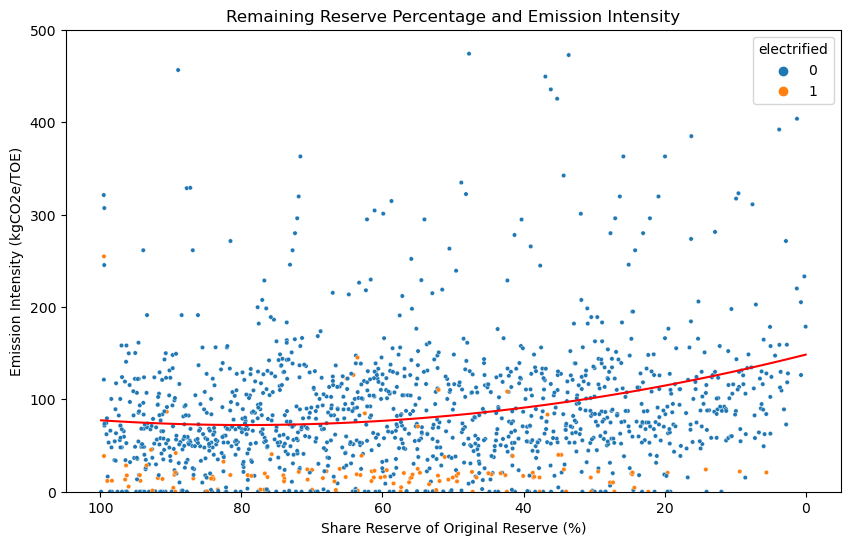

In [120]:
# Set random seeds for reproducibility
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures


random_seed = 42

# Copy the data for DML
data_dml_1 = data.copy()

# Remove fields with negative share_reserve_of_original_reserve
data_dml_1 = data_dml_1[data_dml_1["share_reserve_of_original_reserve"] >= 0]

# Generate the required variables
data_dml_1["processing_field_bin"] = (
    data_dml_1["processing_field"] == data_dml_1["field"]
).astype(float)

# Create dummy variables for operator
field_owner_dummies = pd.get_dummies(data_dml_1["operator"], prefix="operator")
data_dml_1 = pd.concat([data_dml_1, field_owner_dummies], axis=1)

# Define the list of outcomes
outcomes = ["emission_intensity_distributed", "yearly_tco2e_prod_share_emissions"]

# Define the treatment and control variables
D = "share_reserve_of_original_reserve"
X = (
    ["investments_mill_nok", "electrified"]
    + [col for col in data_dml_1.columns if col.startswith("facilities")]
    + [col for col in data_dml_1.columns if col.startswith("subsea_facilites")]
    + [col for col in data_dml_1.columns if col.startswith("surface_")]
    + [col for col in data_dml_1.columns if col.startswith("facility_kind")]
    + [col for col in data_dml_1.columns if col.startswith("well_status")]
    + [col for col in data_dml_1.columns if col.startswith("well_purpose")]
)

# Initialize a dictionary to store the summary statistics
dml_summary_stats = {}

# Iterate over the list of outcomes
for Y in outcomes:
    # Drop rows with NaN values in the relevant columns
    data_dml_1_clean = data_dml_1.dropna(subset=[Y, D] + X)

    # Initialize DoubleMLData object
    dml_data = DoubleMLData(data_dml_1_clean, Y, D, X)

    # Initialize DoubleMLPLR model with different models
    dml_plr = DoubleMLPLR(
        dml_data,
        ml_g=GradientBoostingRegressor(random_state=random_seed),
        ml_m=XGBRegressor(random_state=random_seed),
        ml_l=LinearRegression(),
    )

    # Fit the model
    dml_plr.fit()

    # Extract the results
    coef = dml_plr.coef
    se = dml_plr.se
    t_stat = dml_plr.t_stat
    p_val = dml_plr.pval

    # Store the results in the dictionary
    dml_summary_stats[Y] = {
        "Coefficient": coef[0],
        "Standard Error": se[0],
        "T-Statistic": t_stat[0],
        "P-Value": p_val[0],
    }

# Convert the summary statistics dictionary to a DataFrame
dml_1_summary_df = pd.DataFrame(dml_summary_stats).T

# Display the summary DataFrame
print(f"Comparison of DML Model Results for Different Outcomes: \n(Treatment: {D})")
display(dml_1_summary_df)

# Fit a quadratic polynomial regression model to the total emissions
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(data_dml_1[["share_reserve_of_original_reserve"]])
model = LinearRegression()
model.fit(X_poly, data_dml_1["yearly_tco2e_prod_share_emissions"])

# Extract the coefficients
a, b, c = model.coef_[2], model.coef_[1], model.intercept_

print(
    f"The quadratic equation for the total emissions is: y = {a:.4f}x^2 + {b:.4f}x + {c:.4f}"
)

# Scatter plot with quadratic fit line
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=data_dml_1["share_reserve_of_original_reserve"],
    y=data_dml_1["emission_intensity_distributed"],
    hue=data_dml_1["electrified"],
    s=10,  # Marker size
)

# Fit a quadratic polynomial regression model
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(data_dml_1[["share_reserve_of_original_reserve"]])
model = LinearRegression()
model.fit(X_poly, data_dml_1["emission_intensity_distributed"])

# Extract the coefficients
a, b, c = model.coef_[2], model.coef_[1], model.intercept_

dml_1_equation = {"a": a, "b": b, "c": c}

# Generate points for the fitted quadratic line
x_range = np.linspace(
    data_dml_1["share_reserve_of_original_reserve"].min(),
    data_dml_1["share_reserve_of_original_reserve"].max(),
    100,
)
y_fit = model.predict(poly.transform(x_range.reshape(-1, 1)))

# Plot the fitted quadratic line
plt.plot(x_range, y_fit, color="red")

# Print the quadratic equation
print(
    f"The quadratic equation for emission intensity is: y = {a:.4f}x^2 + {b:.4f}x + {c:.4f}"
)

# Upper Y-axis limit : 500
plt.ylim(0, 500)

plt.xlabel("Share Reserve of Original Reserve (%)")
plt.ylabel("Emission Intensity (kgCO2e/TOE)")
plt.title("Remaining Reserve Percentage and Emission Intensity")
plt.gca().invert_xaxis()
plt.show()

In [115]:
data_dml_1


,field,year,net_oil_prod_yearly_mill_sm3,net_gas_prod_yearly_bill_sm3,net_ngl_prod_yearly_mill_sm3,net_condensate_prod_yearly_mill_sm3,net_oil_eq_prod_yearly_mill_sm3,produced_water_yearly_mill_sm3,field_id,net_oil_prod_monthly_sm3_volatility,net_gas_prod_monthly_sm3_volatility,net_ngl_prod_monthly_sm3_volatility,net_condensate_prod_monthly_sm3_volatility,net_oil_eq_prod_monthly_sm3_volatility,produced_water_in_field_volatility,status,current_status,field_owner,processing_field,field_in_emissions,facilities_lifetime_mean,facilities_lifetime_std,facilities_water_depth_mean,facilities_water_depth_std,subsea_facilites_shut_down,surface_facilites_shut_down,subsea_facilites_in_service,surface_facilites_in_service,facility_kind_multi well template,facility_kind_single well template,facility_kind_offshore wind turbine,facility_kind_subsea structure,facility_kind_fpso,facility_kind_jacket 8 legs,facility_kind_condeep monoshaft,facility_kind_loading system,facility_kind_jacket 4 legs,facility_kind_jacket tripod,facility_kind_fsu,facility_kind_semisub steel,facility_kind_condeep 4 shafts,facility_kind_landfall,facility_kind_tlp concrete,facility_kind_jack-up 3 legs,facility_kind_jacket 6 legs,facility_kind_tlp steel,facility_kind_semisub concrete,facility_kind_mopustor,facility_kind_spar,well_status_closed,well_status_drilling,well_status_injecting,well_status_junked,well_status_online/operational,well_status_p&a,well_status_plugged,well_status_producing,well_status_suspended,well_purpose_injection,well_purpose_observation,well_purpose_production,well_subsea_no,well_subsea_yes,well_final_vertical_depth_mean,well_final_vertical_depth_std,well_water_depth_mean,well_water_depth_std,investments_mill_nok,future_investments_mill_nok,yearly_co2_emissions_1000_tonnes,org_number,operator,yearly_ch4_emissions_tons,yearly_nox_emissions_tons,yearly_oil_spill_emissions_tons,yearly_water_emissions_m3,ownership_original,ownership_new_name,current_remaining_recoverable_oil,current_remaining_recoverable_gas,current_remaining_recoverable_ngl,current_remaining_recoverable_condensate,current_remaining_recoverable_oe,original_recoverable_oil,original_recoverable_gas,original_recoverable_ngl,original_recoverable_condensate,original_recoverable_oe,electrified,years_electrified,electricity_mw,imported_power_2023_gwh/y,year_electrified,yearly_tco2e_gwp100,yearly_tco2e_gwp20,emission_intensity,share_peak_prod,oe_cum_sum_prod,share_reserve_of_original_reserve,oe_fac_prod_mill_sm3,yearly_fac_tco2e_gwp100,oe_share_prod,yearly_tco2e_prod_share_emissions,emission_intensity_distributed,gas_reserve_ratio,oil_reserve_ratio,oil_gas_reserve_ratio,yearly_tco2_emissions,median_production,well_water_depth_mean_20m,processing_field_bin,operator_a/s norske shell,operator_aker bp asa,operator_conocophillips skandinavia as,operator_dno norge as,operator_equinor energy as,operator_okea asa,operator_repsol norge as,operator_vår energi asa,operator_vår energi norge as,operator_wintershall dea norge as
0,statfjord nord,1997-01-01,3.93531,0.17288,0.09230,0.00000,4.20051,0.00000,43679,0.053898,0.000405,0.000334,0.000000,0.054005,0.000000,Producing,Producing,21084.0,statfjord,True,27.500000,15.000000,241.750000,65.030121,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,6.0,9.0,0.0,4.0,0.0,13.0,0.0,17.0,2888.800000,0.000000,285.000000,0.000000,255.0,2946.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'Den norske stats oljeselskap a.s': 50.0, 'Mo...","{'Equinor ASA': 1.875, 'Mobil Development Norw...",3.72,0.23,0.05,0.0,4.05,44.12,2.37,1.12,0.00,48.62,0,0,0,0.0,NaN,NaN,NaN,0.000000,100.000000,4.20051,91.360531,32.43504,1.784085e+06,0.129505,231048.521058,65.481992,0.000049,0.907445,18.616034,NaN,1.542401,5700.000000,0.0,0,0,0,0,0,0,0,0,0,0
1,veslefrikk,1997-01-01,3.47468,0.13919,0.08596,0.00000,3.69981,0.00000,43618,0.052851,0.008952,0.005461,0.000000,0.053418,0.000000,Producing,Shut down,21212.0,veslefrikk,True,NaN,NaN,NaN,NaN,

### DML 2: Share of Peak Production and Emission Intenisity


/Users/pcw/opt/anaconda3/lib/python3.9/site-packages/doubleml/plm/plr.py:122: UserWarning: A learner ml_g has been provided for score = "partialling out" but will be ignored. "A learner ml_g is not required for estimation.
  warnings.warn(('A learner ml_g has been provided for score = "partialling out" but will be ignored. "'
/Users/pcw/opt/anaconda3/lib/python3.9/site-packages/doubleml/plm/plr.py:122: UserWarning: A learner ml_g has been provided for score = "partialling out" but will be ignored. "A learner ml_g is not required for estimation.
  warnings.warn(('A learner ml_g has been provided for score = "partialling out" but will be ignored. "'


Comparison of DML Model Results for Different Outcomes: 
(Treatment: share_peak_prod)


,Coefficient,Standard Error,T-Statistic,P-Value
emission_intensity_distributed,-0.607488,0.097544,-6.227844,4.728976e-10
yearly_tco2e_prod_share_emissions,1357.727734,167.070592,8.126671,4.412408e-16


The quadratic equation for the total emissions is: y = -22.8470x^2 + 4095.7933x + 72032.2182
The quadratic equation for emission intensity is: y = 0.0222x^2 + -3.6032x + 195.0014


/Users/pcw/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


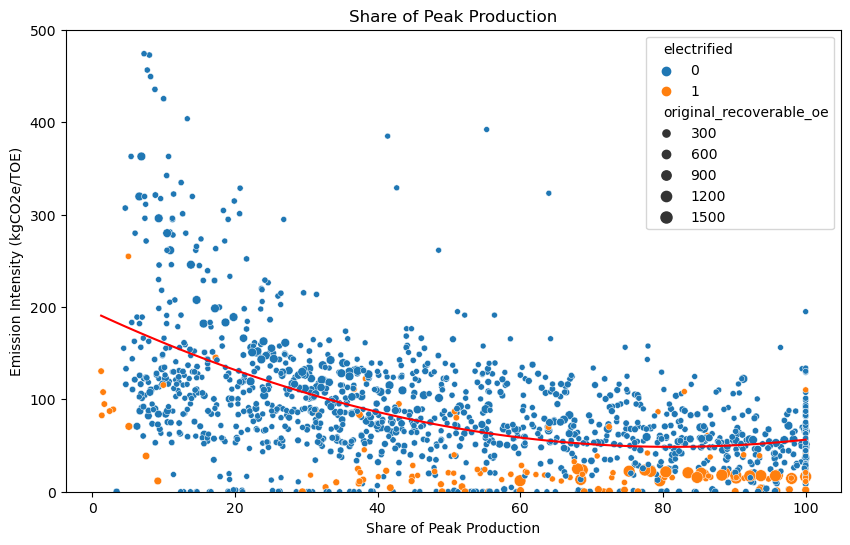

In [126]:
random_seed = 42

# Copy the data for DML
data_dml_2 = data.copy()

# Remove fields with negative share_reserve_of_original_reserve
data_dml_2 = data_dml_2[data_dml_2["share_peak_prod"] >= 0]

# Generate the required variables
data_dml_2["processing_field_bin"] = (
    data_dml_2["processing_field"] == data_dml_2["field"]
).astype(float)

# Create dummy variables for operator
field_owner_dummies = pd.get_dummies(data_dml_2["operator"], prefix="operator")
data_dml_2 = pd.concat([data_dml_2, field_owner_dummies], axis=1)

# Define the list of outcomes
outcomes = ["emission_intensity_distributed", "yearly_tco2e_prod_share_emissions"]

# Define the treatment and control variables
D = "share_peak_prod"
X = (
    ["investments_mill_nok", "electrified"]
    + [col for col in data_dml_2.columns if col.startswith("facilities")]
    + [col for col in data_dml_2.columns if col.startswith("subsea_facilites")]
    + [col for col in data_dml_2.columns if col.startswith("surface_")]
    + [col for col in data_dml_2.columns if col.startswith("facility_kind")]
    + [col for col in data_dml_2.columns if col.startswith("well_status")]
    + [col for col in data_dml_2.columns if col.startswith("well_purpose")]
)

# Initialize a dictionary to store the summary statistics
dml_summary_stats = {}

# Iterate over the list of outcomes
for Y in outcomes:
    # Drop rows with NaN values in the relevant columns
    data_dml_2_clean = data_dml_2.dropna(subset=[Y, D] + X)

    # Initialize DoubleMLData object
    dml_data = DoubleMLData(data_dml_2_clean, Y, D, X)

    # Initialize DoubleMLPLR model with different models
    dml_plr = DoubleMLPLR(
        dml_data,
        ml_g=GradientBoostingRegressor(random_state=random_seed),
        ml_m=XGBRegressor(random_state=random_seed),
        ml_l=LinearRegression(),
    )

    # Fit the model
    dml_plr.fit()

    # Extract the results
    coef = dml_plr.coef
    se = dml_plr.se
    t_stat = dml_plr.t_stat
    p_val = dml_plr.pval

    # Store the results in the dictionary
    dml_summary_stats[Y] = {
        "Coefficient": coef[0],
        "Standard Error": se[0],
        "T-Statistic": t_stat[0],
        "P-Value": p_val[0],
    }

# Convert the summary statistics dictionary to a DataFrame
dml_2_summary_df = pd.DataFrame(dml_summary_stats).T

# Display the summary DataFrame
print(f"Comparison of DML Model Results for Different Outcomes: \n(Treatment: {D})")
display(dml_2_summary_df)

# Fit a quadratic polynomial regression model to the total emissions
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(data_dml_2[["share_peak_prod"]])
model = LinearRegression()
model.fit(X_poly, data_dml_2["yearly_tco2e_prod_share_emissions"])

# Extract the coefficients
a, b, c = model.coef_[2], model.coef_[1], model.intercept_

print(
    f"The quadratic equation for the total emissions is: y = {a:.4f}x^2 + {b:.4f}x + {c:.4f}"
)

# Scatter plot with quadratic fit line
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=data_dml_2["share_peak_prod"],
    y=data_dml_2["emission_intensity_distributed"],
    size=data_dml_2["original_recoverable_oe"],
    hue=data_dml_2["electrified"],
    s=10,  # Marker size
)

# Fit a quadratic polynomial regression model
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(data_dml_2[["share_peak_prod"]])
model = LinearRegression()
model.fit(X_poly, data_dml_2["emission_intensity_distributed"])

# Extract the coefficients
a, b, c = model.coef_[2], model.coef_[1], model.intercept_

dml_2_equation = {"a": a, "b": b, "c": c}

# Generate points for the fitted quadratic line
x_range = np.linspace(
    data_dml_2["share_peak_prod"].min(), data_dml_2["share_peak_prod"].max(), 100
)
y_fit = model.predict(poly.transform(x_range.reshape(-1, 1)))

# Plot the fitted quadratic line
plt.plot(x_range, y_fit, color="red")

# Print the quadratic equation
print(
    f"The quadratic equation for emission intensity is: y = {a:.4f}x^2 + {b:.4f}x + {c:.4f}"
)


# Upper Y-axis limit : 500
plt.ylim(0, 500)

plt.xlabel("Share of Peak Production")
plt.ylabel("Emission Intensity (kgCO2e/TOE)")
plt.title("Share of Peak Production")

plt.show()

### DML 3: Estimating emissions based on Production Volume


/Users/pcw/opt/anaconda3/lib/python3.9/site-packages/doubleml/plm/plr.py:122: UserWarning: A learner ml_g has been provided for score = "partialling out" but will be ignored. "A learner ml_g is not required for estimation.
  warnings.warn(('A learner ml_g has been provided for score = "partialling out" but will be ignored. "'
/Users/pcw/opt/anaconda3/lib/python3.9/site-packages/doubleml/plm/plr.py:122: UserWarning: A learner ml_g has been provided for score = "partialling out" but will be ignored. "A learner ml_g is not required for estimation.
  warnings.warn(('A learner ml_g has been provided for score = "partialling out" but will be ignored. "'


Comparison of DML Model Results for Different Outcomes: 
(Treatment: net_oil_eq_prod_yearly_mill_sm3)


,Coefficient,Standard Error,T-Statistic,P-Value
emission_intensity_distributed,-2.932928,0.844650,-3.472358,0.000516
yearly_tco2e_prod_share_emissions,17987.671303,3905.121224,4.606175,0.000004


The quadratic equation for emission intensity is: y = 0.1234x^2 + -7.1701x + 110.7861


/Users/pcw/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


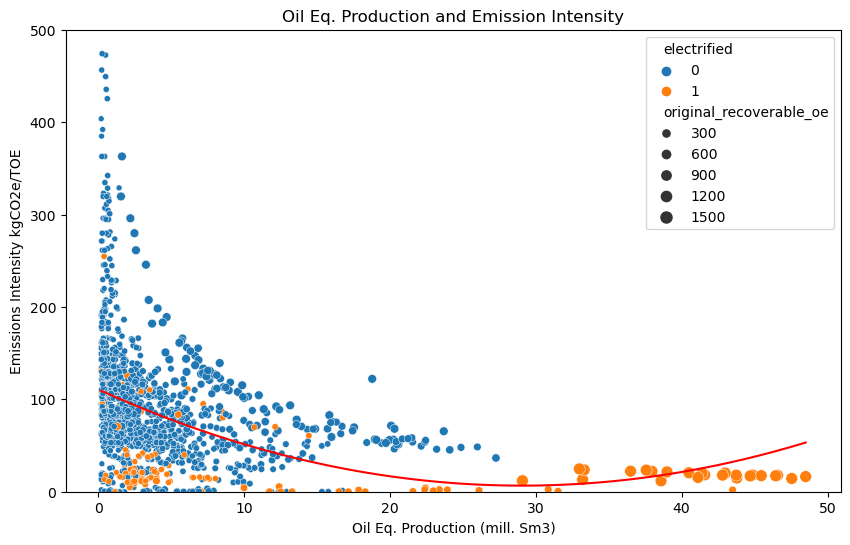

In [125]:
# Set random seeds for reproducibility
random_seed = 42

# Copy the data for DML
data_dml_3 = data.copy()

# Generate the required variables
data_dml_3["processing_field_bin"] = (
    data_dml_3["processing_field"] == data_dml_3["field"]
).astype(float)

# Create dummy variables for operator
field_owner_dummies = pd.get_dummies(data_dml_3["operator"], prefix="operator")
data_dml_3 = pd.concat([data_dml_3, field_owner_dummies], axis=1)

# Define the list of outcomes
outcomes = ["emission_intensity_distributed", "yearly_tco2e_prod_share_emissions"]

# Define the treatment and control variables
D = "net_oil_eq_prod_yearly_mill_sm3"
X = (
    ["investments_mill_nok", "electrified", "future_investments_mill_nok"]
    + [col for col in data_dml_3.columns if col.startswith("facilities")]
    + [col for col in data_dml_3.columns if col.startswith("subsea_facilites")]
    + [col for col in data_dml_3.columns if col.startswith("surface_")]
    + [col for col in data_dml_3.columns if col.startswith("facility_kind")]
    + [col for col in data_dml_3.columns if col.startswith("well_status")]
    + [col for col in data_dml_3.columns if col.startswith("well_purpose")]
)

# Initialize a dictionary to store the summary statistics
dml_summary_stats = {}

# Iterate over the list of outcomes
for Y in outcomes:
    # Drop rows with NaN values in the relevant columns
    data_dml_3_clean = data_dml_3.dropna(subset=[Y, D] + X)

    # Initialize DoubleMLData object
    dml_data = DoubleMLData(data_dml_3_clean, Y, D, X)

    # Initialize DoubleMLPLR model with different models
    dml_plr = DoubleMLPLR(
        dml_data,
        ml_g=GradientBoostingRegressor(random_state=random_seed),
        ml_m=XGBRegressor(random_state=random_seed),
        ml_l=LinearRegression(),
    )

    # Fit the model
    dml_plr.fit()

    # Extract the results
    coef = dml_plr.coef
    se = dml_plr.se
    t_stat = dml_plr.t_stat
    p_val = dml_plr.pval

    # Store the results in the dictionary
    dml_summary_stats[Y] = {
        "Coefficient": coef[0],
        "Standard Error": se[0],
        "T-Statistic": t_stat[0],
        "P-Value": p_val[0],
    }

# Convert the summary statistics dictionary to a DataFrame
dml_1_summary_df = pd.DataFrame(dml_summary_stats).T

# Display the summary DataFrame
print(f"Comparison of DML Model Results for Different Outcomes: \n(Treatment: {D})")
display(dml_1_summary_df)

# Scatter plot with quadratic fit line
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=data_dml_3["net_oil_eq_prod_yearly_mill_sm3"],
    y=data_dml_3["emission_intensity_distributed"],
    # Make the color of the "electrified" field different
    size=data_dml_3["original_recoverable_oe"],
    hue=data_dml_3["electrified"],
    # Set hue to be original_recoverable_oe
    s=15,  # Marker size
)

# Fit a quadratic polynomial regression model
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(data_dml_3[["net_oil_eq_prod_yearly_mill_sm3"]])
model = LinearRegression()
model.fit(X_poly, data_dml_3["emission_intensity_distributed"])

# Extract the coefficients
a, b, c = model.coef_[2], model.coef_[1], model.intercept_

dml_3_equation = {"a": a, "b": b, "c": c}

# Generate points for the fitted quadratic line
x_range = np.linspace(
    data_dml_3["net_oil_eq_prod_yearly_mill_sm3"].min(),
    data_dml_3["net_oil_eq_prod_yearly_mill_sm3"].max(),
    100,
)
y_fit = model.predict(poly.transform(x_range.reshape(-1, 1)))

# Plot the fitted quadratic line
plt.plot(x_range, y_fit, color="red")

# Upper Y-axis limit : 500
plt.ylim(0, 500)


# Print the quadratic equation
print(
    f"The quadratic equation for emission intensity is: y = {a:.4f}x^2 + {b:.4f}x + {c:.4f}"
)
plt.xlabel("Oil Eq. Production (mill. Sm3)")
plt.ylabel("Emissions Intensity kgCO2e/TOE")
plt.title("Oil Eq. Production and Emission Intensity")
plt.show()

/Users/pcw/opt/anaconda3/lib/python3.9/site-packages/doubleml/plm/plr.py:122: UserWarning: A learner ml_g has been provided for score = "partialling out" but will be ignored. "A learner ml_g is not required for estimation.
  warnings.warn(('A learner ml_g has been provided for score = "partialling out" but will be ignored. "'
/Users/pcw/opt/anaconda3/lib/python3.9/site-packages/doubleml/plm/plr.py:122: UserWarning: A learner ml_g has been provided for score = "partialling out" but will be ignored. "A learner ml_g is not required for estimation.
  warnings.warn(('A learner ml_g has been provided for score = "partialling out" but will be ignored. "'


Comparison of DML Model Results for Different Outcomes: 
(Treatment: original_recoverable_oe)


,Coefficient,Standard Error,T-Statistic,P-Value
emission_intensity_distributed,-0.002309,0.005756,-0.401118,6.883333e-01
yearly_tco2e_prod_share_emissions,158.973834,11.380418,13.969069,2.407548e-44


The quadratic equation for emission intensity is: y = -0.0000x^2 + -0.0068x + 90.1526


/Users/pcw/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


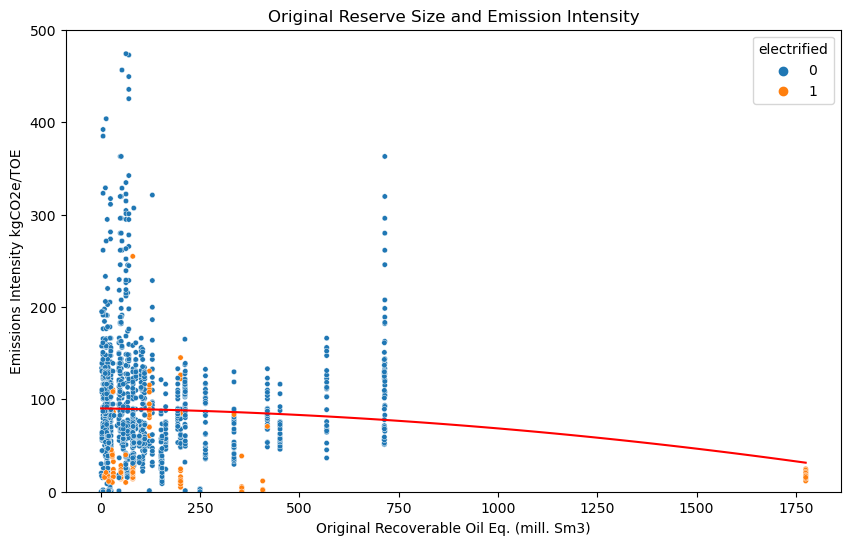

In [143]:
# Set random seeds for reproducibility
random_seed = 42

# Copy the data for DML
data_dml_4 = data.copy()

# Generate the required variables
data_dml_4["processing_field_bin"] = (
    data_dml_4["processing_field"] == data_dml_4["field"]
).astype(float)

# Create dummy variables for operator
field_owner_dummies = pd.get_dummies(data_dml_4["operator"], prefix="operator")
data_dml_4 = pd.concat([data_dml_4, field_owner_dummies], axis=1)

# Define the list of outcomes
outcomes = ["emission_intensity_distributed", "yearly_tco2e_prod_share_emissions"]

# Define the treatment and control variables
D = "original_recoverable_oe"
X = (
    ["investments_mill_nok", "electrified", "future_investments_mill_nok"]
    + [col for col in data_dml_4.columns if col.startswith("facilities")]
    + [col for col in data_dml_4.columns if col.startswith("subsea_facilites")]
    + [col for col in data_dml_4.columns if col.startswith("surface_")]
    + [col for col in data_dml_4.columns if col.startswith("facility_kind")]
    + [col for col in data_dml_4.columns if col.startswith("well_status")]
    + [col for col in data_dml_4.columns if col.startswith("well_purpose")]
)

# Initialize a dictionary to store the summary statistics
dml_summary_stats = {}

# Iterate over the list of outcomes
for Y in outcomes:
    # Drop rows with NaN values in the relevant columns
    data_dml_4_clean = data_dml_4.dropna(subset=[Y, D] + X)

    # Initialize DoubleMLData object
    dml_data = DoubleMLData(data_dml_4_clean, Y, D, X)

    # Initialize DoubleMLPLR model with different models
    dml_plr = DoubleMLPLR(
        dml_data,
        ml_g=GradientBoostingRegressor(random_state=random_seed),
        ml_m=XGBRegressor(random_state=random_seed),
        ml_l=LinearRegression(),
    )

    # Fit the model
    dml_plr.fit()

    # Extract the results
    coef = dml_plr.coef
    se = dml_plr.se
    t_stat = dml_plr.t_stat
    p_val = dml_plr.pval

    # Store the results in the dictionary
    dml_summary_stats[Y] = {
        "Coefficient": coef[0],
        "Standard Error": se[0],
        "T-Statistic": t_stat[0],
        "P-Value": p_val[0],
    }

# Convert the summary statistics dictionary to a DataFrame
dml_1_summary_df = pd.DataFrame(dml_summary_stats).T

# Display the summary DataFrame
print(f"Comparison of DML Model Results for Different Outcomes: \n(Treatment: {D})")
display(dml_1_summary_df)

# Scatter plot with quadratic fit line
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=data_dml_4["original_recoverable_oe"],
    y=data_dml_4["emission_intensity_distributed"],
    # Make the color of the "electrified" field different
    # size=data_dml_4["original_recoverable_oe"],
    hue=data_dml_4["electrified"],
    # Set hue to be original_recoverable_oe
    s=15,  # Marker size
)

# Fit a quadratic polynomial regression model
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(data_dml_4[["original_recoverable_oe"]])
model = LinearRegression()
model.fit(X_poly, data_dml_4["emission_intensity_distributed"])

# Extract the coefficients
a, b, c = model.coef_[2], model.coef_[1], model.intercept_

dml_4_equation = {"a": a, "b": b, "c": c}

# Generate points for the fitted quadratic line
x_range = np.linspace(
    data_dml_4["original_recoverable_oe"].min(),
    data_dml_4["original_recoverable_oe"].max(),
    100,
)
y_fit = model.predict(poly.transform(x_range.reshape(-1, 1)))

# Plot the fitted quadratic line
plt.plot(x_range, y_fit, color="red")

# Upper Y-axis limit : 500
plt.ylim(0, 500)


# Print the quadratic equation
print(
    f"The quadratic equation for emission intensity is: y = {a:.4f}x^2 + {b:.4f}x + {c:.4f}"
)
plt.xlabel("Original Recoverable Oil Eq. (mill. Sm3)")
plt.ylabel("Emissions Intensity kgCO2e/TOE")
plt.title("Original Reserve Size and Emission Intensity")
plt.show()


In [73]:
data_dml_3


,field,year,net_oil_prod_yearly_mill_sm3,net_gas_prod_yearly_bill_sm3,net_ngl_prod_yearly_mill_sm3,net_condensate_prod_yearly_mill_sm3,net_oil_eq_prod_yearly_mill_sm3,produced_water_yearly_mill_sm3,field_id,net_oil_prod_monthly_sm3_volatility,net_gas_prod_monthly_sm3_volatility,net_ngl_prod_monthly_sm3_volatility,net_condensate_prod_monthly_sm3_volatility,net_oil_eq_prod_monthly_sm3_volatility,produced_water_in_field_volatility,status,current_status,field_owner,processing_field,field_in_emissions,facilities_lifetime_mean,facilities_lifetime_std,facilities_water_depth_mean,facilities_water_depth_std,subsea_facilites_shut_down,surface_facilites_shut_down,subsea_facilites_in_service,surface_facilites_in_service,facility_kind_multi well template,facility_kind_single well template,facility_kind_offshore wind turbine,facility_kind_subsea structure,facility_kind_fpso,facility_kind_jacket 8 legs,facility_kind_condeep monoshaft,facility_kind_loading system,facility_kind_jacket 4 legs,facility_kind_jacket tripod,facility_kind_fsu,facility_kind_semisub steel,facility_kind_condeep 4 shafts,facility_kind_landfall,facility_kind_tlp concrete,facility_kind_jack-up 3 legs,facility_kind_jacket 6 legs,facility_kind_tlp steel,facility_kind_semisub concrete,facility_kind_mopustor,facility_kind_spar,well_status_closed,well_status_drilling,well_status_injecting,well_status_junked,well_status_online/operational,well_status_p&a,well_status_plugged,well_status_producing,well_status_suspended,well_purpose_injection,well_purpose_observation,well_purpose_production,well_subsea_no,well_subsea_yes,well_final_vertical_depth_mean,well_final_vertical_depth_std,well_water_depth_mean,well_water_depth_std,investments_mill_nok,future_investments_mill_nok,yearly_co2_emissions_1000_tonnes,org_number,operator,yearly_ch4_emissions_tons,yearly_nox_emissions_tons,yearly_oil_spill_emissions_tons,yearly_water_emissions_m3,ownership_original,ownership_new_name,current_remaining_recoverable_oil,current_remaining_recoverable_gas,current_remaining_recoverable_ngl,current_remaining_recoverable_condensate,current_remaining_recoverable_oe,original_recoverable_oil,original_recoverable_gas,original_recoverable_ngl,original_recoverable_condensate,original_recoverable_oe,electrified,years_electrified,electricity_mw,imported_power_2023_gwh/y,year_electrified,yearly_tco2e_gwp100,yearly_tco2e_gwp20,emission_intensity,share_peak_prod,oe_cum_sum_prod,share_reserve_of_original_reserve,oe_fac_prod_mill_sm3,yearly_fac_tco2e_gwp100,oe_share_prod,yearly_tco2e_prod_share_emissions,emission_intensity_distributed,gas_reserve_ratio,oil_reserve_ratio,oil_gas_reserve_ratio,yearly_tco2_emissions,median_production,well_water_depth_mean_20m,processing_field_bin,operator_a/s norske shell,operator_aker bp asa,operator_conocophillips skandinavia as,operator_dno norge as,operator_equinor energy as,operator_okea asa,operator_repsol norge as,operator_vår energi asa,operator_vår energi norge as,operator_wintershall dea norge as
0,statfjord nord,1997-01-01,3.93531,0.17288,0.09230,0.00000,4.20051,0.00000,43679,0.053898,0.000405,0.000334,0.000000,0.054005,0.000000,Producing,Producing,21084.0,statfjord,True,27.500000,15.000000,241.750000,65.030121,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,6.0,9.0,0.0,4.0,0.0,13.0,0.0,17.0,2888.800000,0.000000,285.000000,0.000000,255.0,2946.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'Den norske stats oljeselskap a.s': 50.0, 'Mo...","{'Equinor ASA': 1.875, 'Mobil Development Norw...",3.72,0.23,0.05,0.0,4.05,44.12,2.37,1.12,0.00,48.62,0,0,0,0.0,NaN,NaN,NaN,0.000000,100.000000,4.20051,91.360531,32.43504,1.784085e+06,0.129505,231048.521058,65.481992,0.000049,0.907445,18.616034,NaN,1.542401,5700.000000,0.0,0,0,0,0,0,0,0,0,0,0
1,veslefrikk,1997-01-01,3.47468,0.13919,0.08596,0.00000,3.69981,0.00000,43618,0.052851,0.008952,0.005461,0.000000,0.053418,0.000000,Producing,Shut down,21212.0,veslefrikk,True,NaN,NaN,NaN,NaN,

## Predicting Future Production and Emissions


In [42]:
# Checking how many fields have more than 0 in current remaining recoverable oil eq.

data_producing = data[data["current_status"] == "Producing"]
data_producing[data_producing["current_remaining_recoverable_oe"] > 0][
    "field"
].nunique()

85

In [43]:
data.net_oil_eq_prod_yearly_mill_sm3.describe()

count    1445.000000
mean        4.398490
std         6.904257
min         0.201610
25%         0.710210
50%         2.053830
75%         4.983730
max        48.502120
Name: net_oil_eq_prod_yearly_mill_sm3, dtype: float64

In [44]:
# Create a column called median_production for each field
data["median_production"] = data.groupby("field")[
    "net_oil_eq_prod_yearly_mill_sm3"
].transform("mean")

# Checking Nan values in the median_production column
data["median_production"].isna().sum()

0

In [122]:
producing_data["current_remaining_recoverable_oe"].aggregate("sum")

40917.66

Dataset shape after preprocessing: (1274, 110)


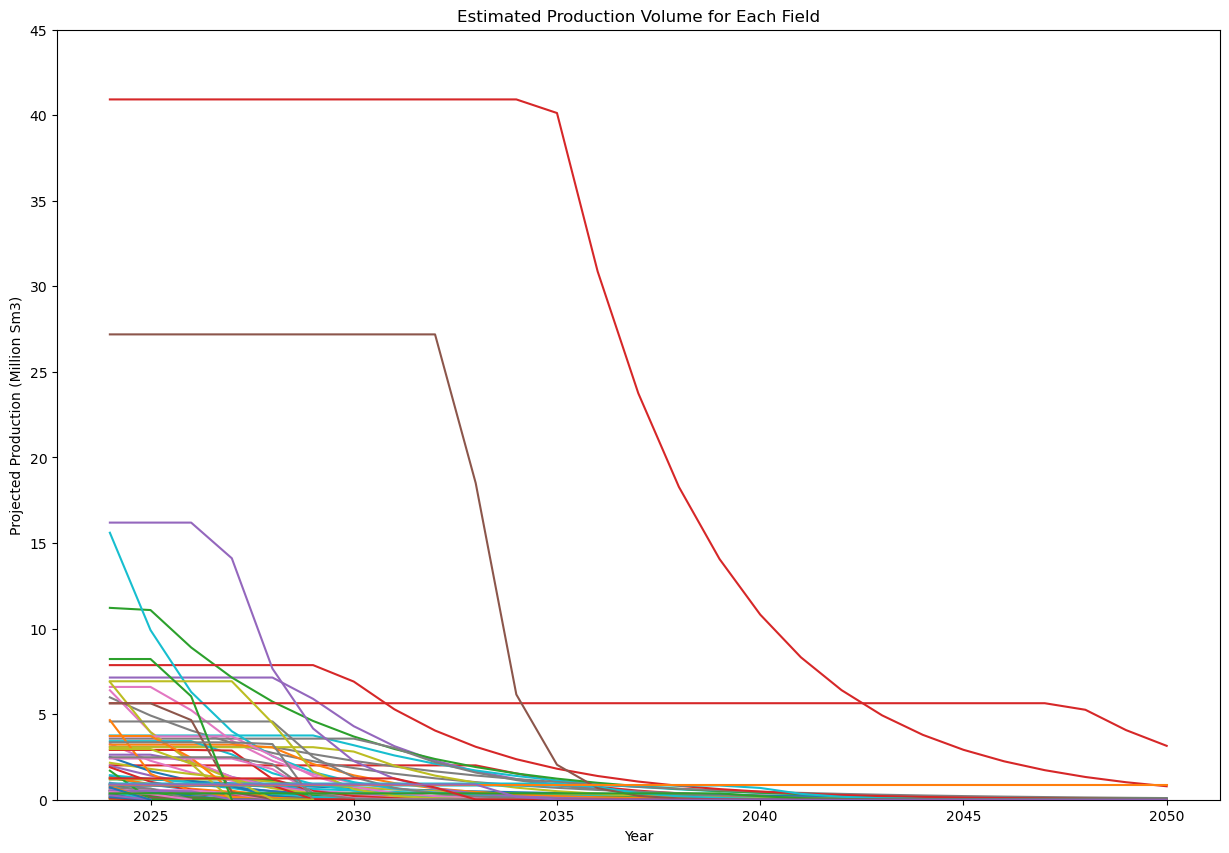

In [83]:
# Filter for producing fields and calculate median yearly production
producing_data = data.copy()
producing_data = producing_data[producing_data["current_remaining_recoverable_oe"] > 0]

# Define the ramp-down threshold
ramp_down_threshold = 0.1

# Print dataset information after preprocessing
print(f"Dataset shape after preprocessing: {producing_data.shape}")

# Simplified production forecast
future_years = list(range(2024, 2050))
fields = producing_data["field"].unique()

future_predictions = []

for field in fields:
    median_production = producing_data[producing_data["field"] == field][
        "median_production"
    ].iloc[0]
    current_reserve = producing_data[producing_data["field"] == field][
        "current_remaining_recoverable_oe"
    ].iloc[0]
    original_recoverable = producing_data[producing_data["field"] == field][
        "original_recoverable_oe"
    ].iloc[0]
    cumulative_production = 0
    year = 2024

    while current_reserve > 0 and year <= 2050:
        if current_reserve <= ramp_down_threshold * original_recoverable:
            production_for_year = max(
                median_production
                * (current_reserve / (ramp_down_threshold * original_recoverable)),
                0,
            )
        else:
            production_for_year = (
                median_production
                if current_reserve >= median_production
                else current_reserve
            )

        cumulative_production += production_for_year
        future_predictions.append(
            {
                "field": field,
                "year": year,
                "predicted_production": production_for_year,
                "cumulative_production": cumulative_production,
                "years_left": np.round(current_reserve / median_production, 0),
            }
        )
        current_reserve -= production_for_year
        year += 1

    if current_reserve <= 0:
        future_predictions.append(
            {
                "field": field,
                "year": year,
                "predicted_production": 0,
                "cumulative_production": cumulative_production,
                "years_left": 0,
            }
        )

# Create a DataFrame for future predictions
future_predictions_df = pd.DataFrame(future_predictions)

# Visualize the estimated production for each field
plt.figure(figsize=(15, 10))
for field in future_predictions_df["field"].unique():
    field_data = future_predictions_df[future_predictions_df["field"] == field]
    plt.plot(field_data["year"], field_data["predicted_production"], label=field)

plt.xlabel("Year")
plt.ylabel("Projected Production (Million Sm3)")
plt.title("Estimated Production Volume for Each Field")
plt.ylim(0, 45)  # Set the y-axis limit to better visualize the data
# plt.legend(title="Field", loc="upper right", bbox_to_anchor=(1.2, 1))
plt.show()

In [84]:
future_predictions_df.describe()

,year,predicted_production,cumulative_production,years_left
count,1918.000000,1918.000000,1918.000000,1918.000000
mean,2036.673618,1.085090,22.477511,1.571950
std,7.914504,4.131373,64.457255,4.308861
min,2024.000000,0.000000,0.022858,0.000000
25%,2030.000000,0.000017,1.510000,0.000000
50%,2037.000000,0.017698,6.899998,0.000000
75%,2044.000000,0.489127,16.658555,1.000000
max,2050.000000,40.926430,621.595791,38.000000


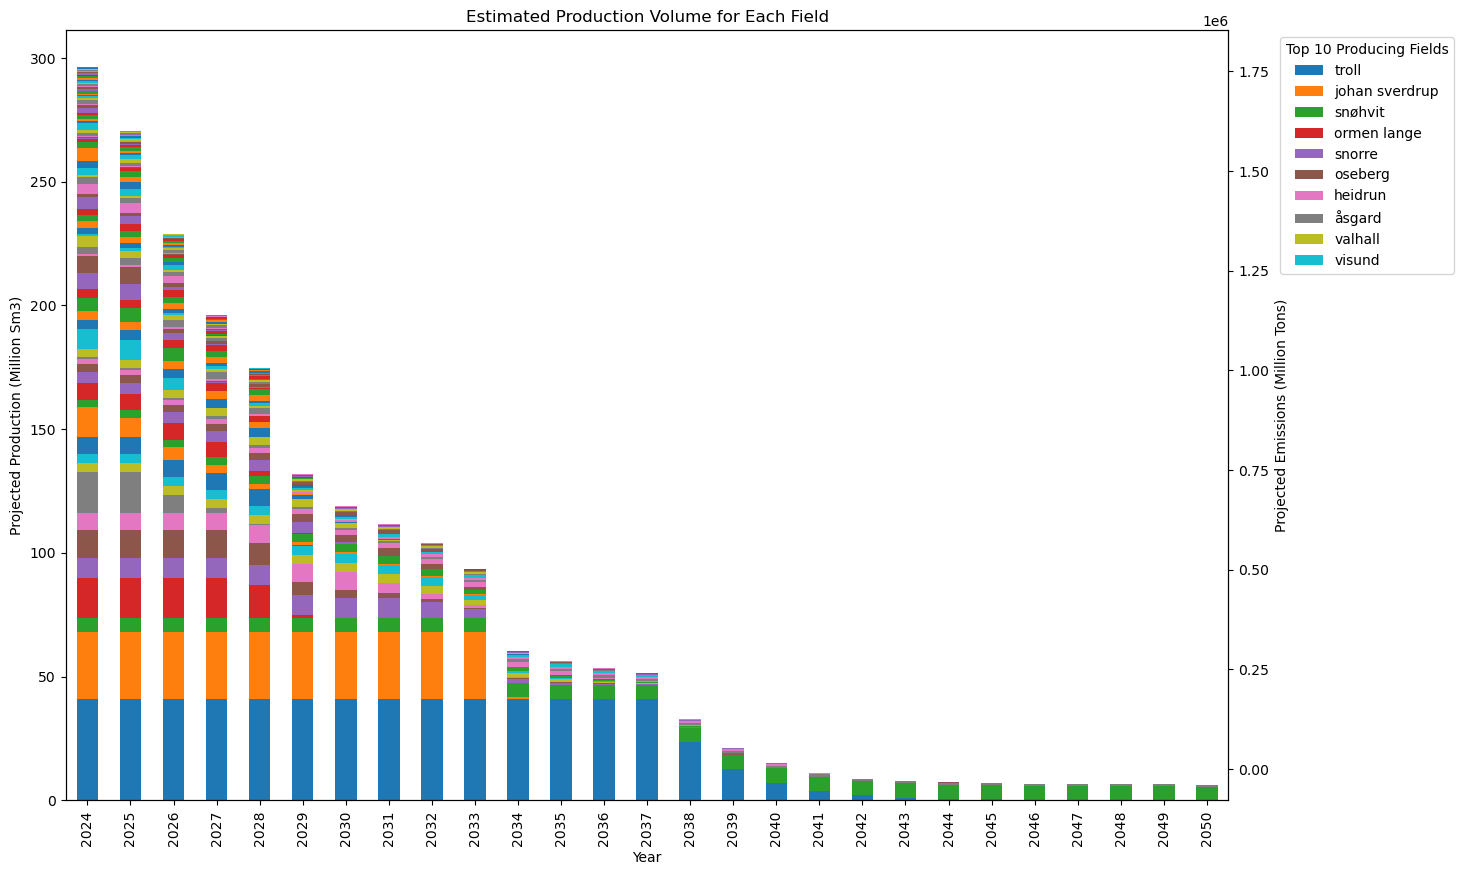

In [106]:
# Create a neat stacked bar chart with the total production for each year. Use future_predictions_df. Split color by field

# Create a pivot table for the future predictions
pivot_table = future_predictions_df.pivot(
    index="year", columns="field", values="predicted_production"
)

# Fill NaN values with 0
pivot_table = pivot_table.fillna(0)

# Sort after highest production field
pivot_table = pivot_table[pivot_table.sum().sort_values(ascending=False).index]
# Create a stacked bar chart
pivot_table.plot(kind="bar", stacked=True, figsize=(15, 10))
plt.xlabel("Year")
plt.ylabel("Projected Production (Million Sm3)")
plt.title("Estimated Production Volume for Each Field")
# plt.legend(title="Field", loc="upper right", bbox_to_anchor=(1.2, 1))

# Hide legend

# Show legend with top 10 highest producing fields

plt.legend(
    title="Top 10 Producing Fields",
    loc="upper right",
    bbox_to_anchor=(1.2, 1),
    labels=pivot_table.columns[:10],
)

# In the same graph, but on the right side, show show the total yearly emissions (not cumaltive) for each year - as a line plot
plt.twinx()
plt.plot(future_predictions_df.groupby("year")["total_emissions"].sum(), color="black")
plt.ylabel("Total Projected Production (Million Sm3)")

plt.ylabel("Projected Emissions (Million Tons)")

plt.show()


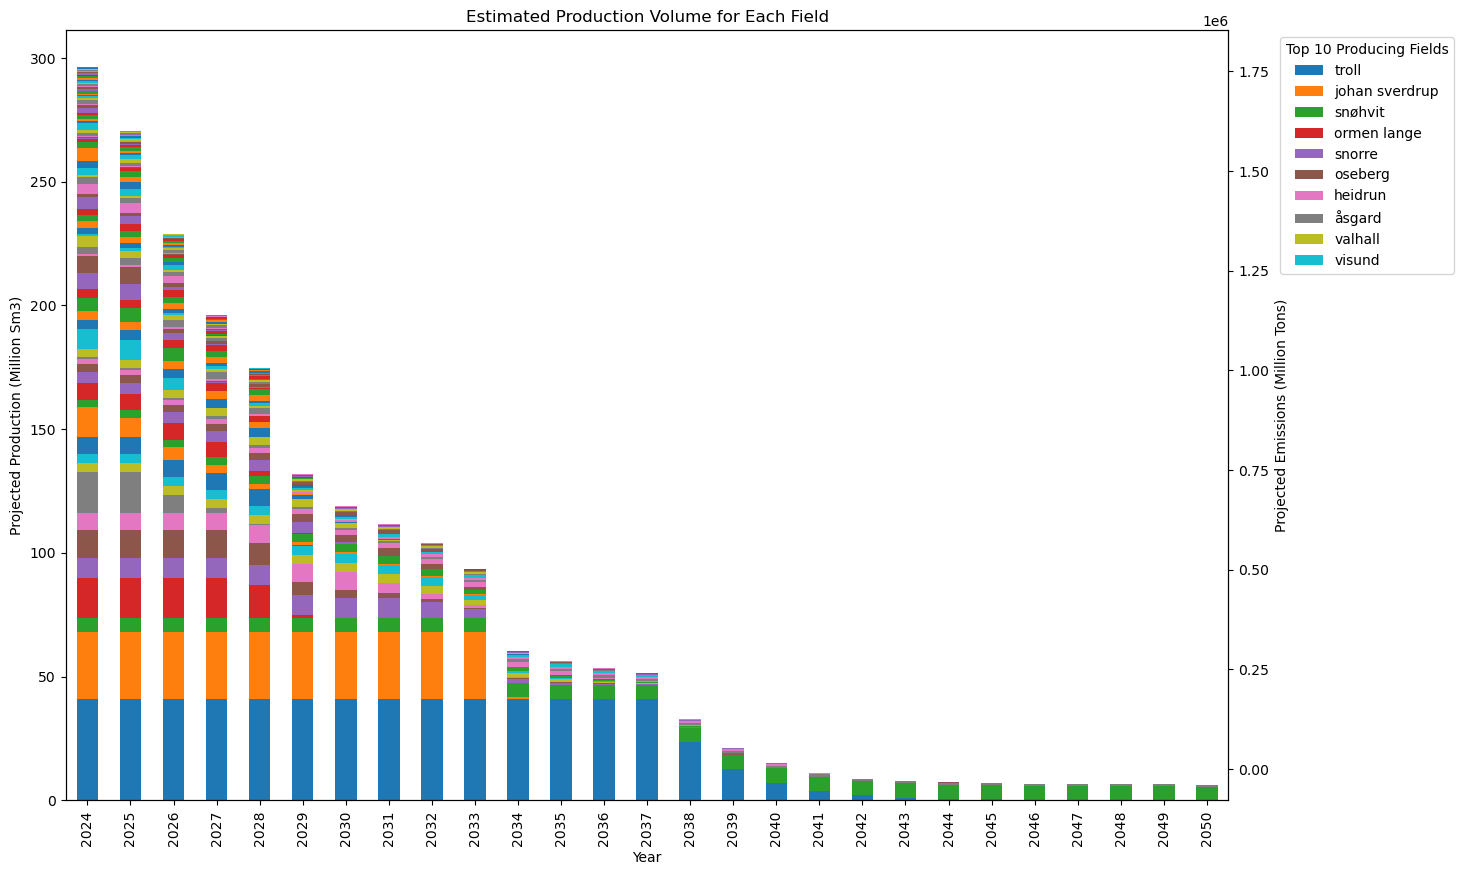

In [109]:
import matplotlib.pyplot as plt

# Create a neat stacked bar chart with the total production for each year. Use future_predictions_df. Split color by field

# Create a pivot table for the future predictions
pivot_table = future_predictions_df.pivot(
    index="year", columns="field", values="predicted_production"
)

# Fill NaN values with 0
pivot_table = pivot_table.fillna(0)

# Sort after highest production field
pivot_table = pivot_table[pivot_table.sum().sort_values(ascending=False).index]

# Create a figure and the first axis
fig, ax1 = plt.subplots(figsize=(15, 10))
# Create a second y-axis for the emissions plot
ax2 = ax1.twinx()
ax2.plot(
    future_predictions_df.groupby("year")["total_emissions"].sum(),
    color="black",
    linestyle="--",
    marker="o",
)
ax2.set_ylabel("Projected Emissions (Million Tons)")

# Create the stacked bar chart
pivot_table.plot(kind="bar", stacked=True, ax=ax1, legend=False)
ax1.set_xlabel("Year")
ax1.set_ylabel("Projected Production (Million Sm3)")
ax1.set_title("Estimated Production Volume for Each Field")


# Show the legend for the top 10 highest producing fields
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(
    handles[:10],
    labels[:10],
    title="Top 10 Producing Fields",
    loc="upper right",
    bbox_to_anchor=(1.2, 1),
)

# Show the plot
plt.show()


In [102]:
future_predictions_df


,field,year,predicted_production,cumulative_production,total_emissions,years_left,reserve,mean_emission_intensity_distributed
0,statfjord nord,2024,1.542401,1.542401,31905.685669,3.0,4.050000,164.031554
1,statfjord nord,2025,1.542401,3.084802,32328.536506,2.0,2.507599,164.031554
2,statfjord nord,2026,0.612391,3.697193,13406.403032,1.0,0.965198,164.031554
3,statfjord nord,2027,0.223846,3.921039,4988.220807,0.0,0.352807,164.031554
4,statfjord nord,2028,0.081822,4.002861,1835.171342,0.0,0.128961,164.031554
...,...,...,...,...,...,...,...,...
1319,fenja,2031,0.889540,7.116320,8704.090423,3.0,2.853220,87.033573
1320,fenja,2032,0.889540,8.005860,8983.287469,2.0,1.963680,87.033573
1321,fenja,2033,0.889540,8.895400,9308.647692,1.0,1.074140,87.033573
1322,fenja,2034,0.334779,9.230179,3841.613227,0.0,0.184600,87.033573


In [46]:
future_predictions_df.years_left.describe()

count    1918.000000
mean        1.571950
std         4.308861
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        38.000000
Name: years_left, dtype: float64

In [47]:
future_predictions_df.head()

,field,year,predicted_production,cumulative_production,years_left
0,statfjord nord,2024,1.284805,1.284805,3.0
1,statfjord nord,2025,0.877219,2.162024,2.0
2,statfjord nord,2026,0.598934,2.760958,1.0
3,statfjord nord,2027,0.408930,3.169888,1.0
4,statfjord nord,2028,0.279203,3.449091,1.0


In [48]:
future_predictions_df[future_predictions_df["field"] == "troll"]

,field,year,predicted_production,cumulative_production,years_left
351,troll,2024,40.926430,40.926430,15.0
352,troll,2025,40.926430,81.852859,14.0
353,troll,2026,40.926430,122.779289,13.0
354,troll,2027,40.926430,163.705719,12.0
355,troll,2028,40.926430,204.632148,11.0
356,troll,2029,40.926430,245.558578,10.0
357,troll,2030,40.926430,286.485007,9.0
358,troll,2031,40.926430,327.411437,8.0
359,troll,2032,40.926430,368.337867,7.0
360,troll,2033,40.926430,409.264296,6.0


Dataset shape after preprocessing: (1274, 111)


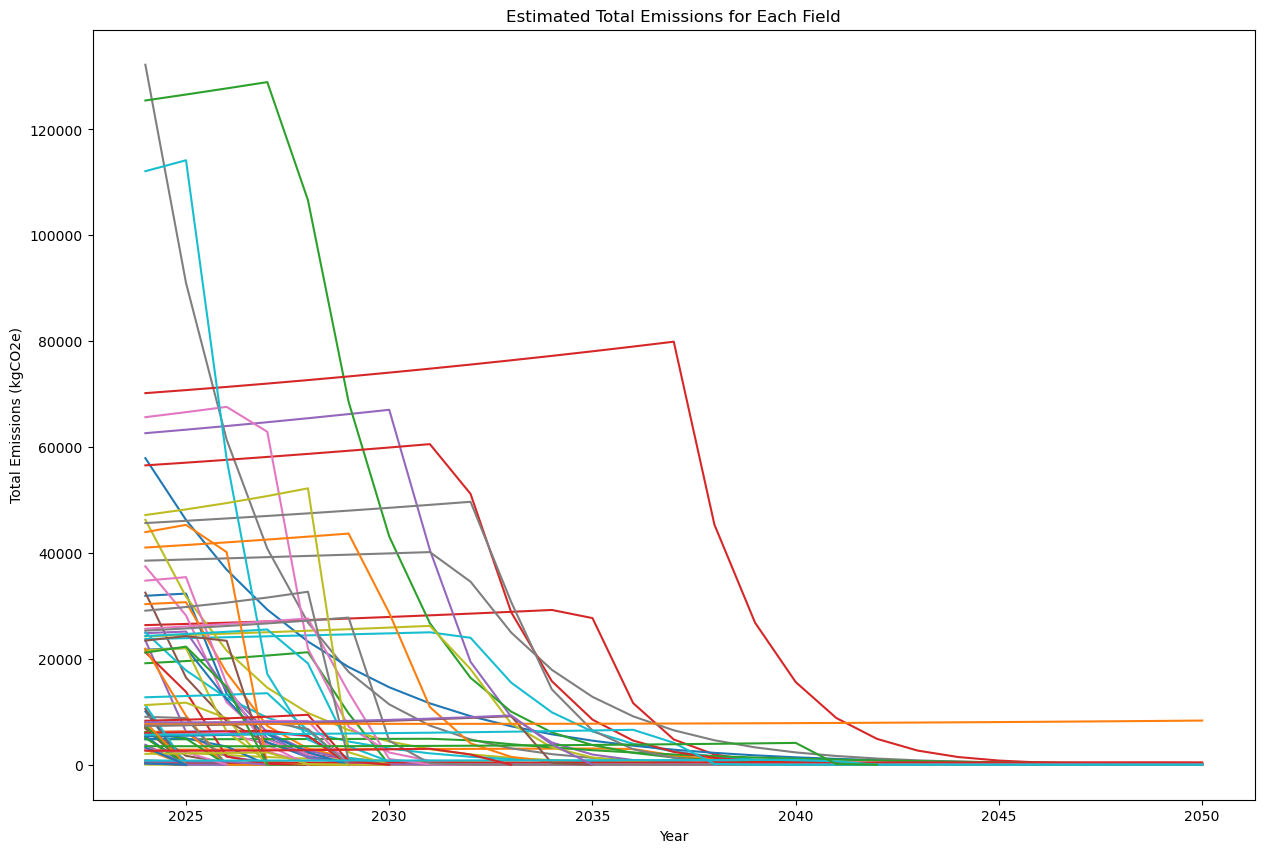

In [86]:
producing_data = data.copy()

# Filter for producing fields and calculate median yearly production
producing_data = producing_data[producing_data["current_remaining_recoverable_oe"] > 0]

# Calculate the mean emission intensity for each field
producing_data["mean_emission_intensity_distributed"] = producing_data.groupby("field")[
    "emission_intensity_distributed"
].transform("mean")


def emission_intensity_adjustment(eq, x):
    a, b, c = eq["a"], eq["b"], eq["c"]
    return a * x**2 + b * x + c


# Define the ramp-down threshold
ramp_down_threshold = 0.05

# Print dataset information after preprocessing
print(f"Dataset shape after preprocessing: {producing_data.shape}")

# Simplified production forecast
future_years = list(range(2024, 2050))
fields = producing_data["field"].unique()

future_predictions = []

for field in fields:
    median_production = producing_data[producing_data["field"] == field][
        "median_production"
    ].iloc[0]
    current_reserve = producing_data[producing_data["field"] == field][
        "current_remaining_recoverable_oe"
    ].iloc[0]
    original_recoverable = producing_data[producing_data["field"] == field][
        "original_recoverable_oe"
    ].iloc[0]
    current_emission_intensity = producing_data[producing_data["field"] == field][
        "mean_emission_intensity_distributed"
    ].iloc[0]
    cumulative_production = 0
    year = 2024

    while current_reserve > 0 and year <= 2050:
        if current_reserve <= ramp_down_threshold * original_recoverable:
            production_for_year = max(
                median_production
                * (current_reserve / (ramp_down_threshold * original_recoverable)),
                0,
            )
        else:
            production_for_year = (
                median_production
                if current_reserve >= median_production
                else current_reserve
            )

        cumulative_production += production_for_year

        share_of_peak_prod = production_for_year / original_recoverable
        remaining_reserve_percentage = current_reserve / original_recoverable

        adjustment_1 = emission_intensity_adjustment(
            dml_1_equation, remaining_reserve_percentage * 100
        )
        adjustment_2 = emission_intensity_adjustment(
            dml_2_equation, share_of_peak_prod * 100
        )
        adjustment_3 = emission_intensity_adjustment(
            dml_3_equation, production_for_year
        )

        adjustment_effect = (adjustment_1 + adjustment_2 + adjustment_3) / 3

        # Apply the adjustments with equal weighting
        # final_emission_intensity = current_emission_intensity * (1 + (adjustment_1 + adjustment_2 + adjustment_3) / 3)

        # Apply the adjustments with equal weighting
        # final_emission_intensity = current_emission_intensity * (1 + (adjustment_1 + adjustment_2 + adjustment_3) / 3)
        # total_emissions = production_for_year * final_emission_intensity

        # Define weights for the current emission intensity and adjustments
        weight_current_intensity = (
            0.1  # Less influence on the current emission intensity
        )
        weight_adjustments = 0.9  # More influence on the adjustments

        # final_emission_intensity = (weight_current_intensity * current_emission_intensity
        # + weight_adjustments * current_emission_intensity * (1 + adjustment_effect))

        final_emission_intensity = (
            weight_current_intensity * current_emission_intensity
            + weight_adjustments * current_emission_intensity * (1 + adjustment_effect)
        )

        total_emissions = production_for_year * final_emission_intensity

        future_predictions.append(
            {
                "field": field,
                "year": year,
                "predicted_production": production_for_year,
                "cumulative_production": cumulative_production,
                "total_emissions": total_emissions,
                "years_left": np.round(current_reserve / median_production, 0),
                "reserve": current_reserve,
                "mean_emission_intensity_distributed": current_emission_intensity,
            }
        )
        current_reserve -= production_for_year
        year += 1

    if current_reserve <= 0:
        future_predictions.append(
            {
                "field": field,
                "year": year,
                "predicted_production": 0,
                "cumulative_production": cumulative_production,
                "total_emissions": 0,
                "years_left": 0,
                "reserve": current_reserve,
                "mean_emission_intensity_distributed": current_emission_intensity,
            }
        )

# Create a DataFrame for future predictions
future_predictions_df = pd.DataFrame(future_predictions)

# Plot the estimated total emissions for each field
plt.figure(figsize=(15, 10))
for field in future_predictions_df["field"].unique():
    field_data = future_predictions_df[future_predictions_df["field"] == field]
    plt.plot(field_data["year"], field_data["total_emissions"], label=field)

plt.xlabel("Year")
plt.ylabel("Total Emissions (kgCO2e)")
plt.title("Estimated Total Emissions for Each Field")
plt.show()

In [90]:
future_predictions_df.describe()

,year,predicted_production,cumulative_production,total_emissions,years_left,reserve,mean_emission_intensity_distributed
count,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000
mean,2035.456949,1.579461,27.702320,7379.515360,2.149547,10.167548,74.130184
std,8.101424,5.142603,73.182270,16976.656385,5.052887,45.131041,46.179736
min,2024.000000,0.000000,0.045716,0.000000,0.000000,-0.550281,0.675399
25%,2028.000000,0.000001,3.569162,0.007046,0.000000,0.000002,47.891370
50%,2035.000000,0.017113,10.799003,161.421930,0.000000,0.035449,68.360448
75%,2042.000000,0.852020,27.714749,6001.944378,2.000000,3.250103,100.862818
max,2050.000000,40.926430,624.203476,132215.910224,38.000000,624.220000,224.717191


In [50]:
# future_predictions_df
future_predictions_df[future_predictions_df["field"] == "troll"]

,field,year,predicted_production,cumulative_production,total_emissions,years_left,reserve,mean_emission_intensity_distributed
331,troll,2024,40.926430,40.926430,70184.673308,15.0,624.220000,18.444163
332,troll,2025,40.926430,81.852859,70757.447458,14.0,583.293570,18.444163
333,troll,2026,40.926430,122.779289,71359.332559,13.0,542.367141,18.444163
334,troll,2027,40.926430,163.705719,71990.328609,12.0,501.440711,18.444163
335,troll,2028,40.926430,204.632148,72650.435610,11.0,460.514281,18.444163
336,troll,2029,40.926430,245.558578,73339.653562,10.0,419.587852,18.444163
337,troll,2030,40.926430,286.485007,74057.982464,9.0,378.661422,18.444163
338,troll,2031,40.926430,327.411437,74805.422316,8.0,337.734993,18.444163
339,troll,2032,40.926430,368.337867,75581.973118,7.0,296.808563,18.444163
340,troll,2033,40.926430,409.264296,76387.634871,6.0,255.882133,18.444163


In [89]:
# Creating a table to show, top 5 producers in cumalitve, total emissions, and average emission intensities

# Calculate the cumulative production and total emissions for each field
cumulative_production = future_predictions_df.groupby("field")[
    "cumulative_production"
].max()

total_emissions = future_predictions_df.groupby("field")["total_emissions"].max()

average_emission_intensity = future_predictions_df.groupby("field")[
    "mean_emission_intensity_distributed"
].mean()

# Create a DataFrame for the top 5 producers in cumulative production
top_5_cumulative = (
    cumulative_production.sort_values(ascending=False).head(5).reset_index()
)
top_5_cumulative.columns = ["Field", "Cumulative Production"]

# Create a DataFrame for the top 5 producers in total emissions
top_5_emissions = total_emissions.sort_values(ascending=False).head(5).reset_index()
top_5_emissions.columns = ["Field", "Total Emissions"]

# Create a DataFrame for the top 5 producers in average emission intensity
top_5_intensity = (
    average_emission_intensity.sort_values(ascending=True).head(5).reset_index()
)
top_5_intensity.columns = ["Field", "Average Emission Intensity"]

# Display the top 5 producers in each category
print("Top 5 Producers in Cumulative Production:")

display(top_5_cumulative)

print("\nTop 5 Producers in Total Emissions:")
display(top_5_emissions)

print("\Lowest 5  Average Emission Intensity:")
display(top_5_intensity)


Top 5 Producers in Cumulative Production:


,Field,Cumulative Production
0,troll,624.203476
1,johan sverdrup,272.645363
2,snøhvit,152.052109
3,ormen lange,79.460000
4,snorre,76.609920



Top 5 Producers in Total Emissions:


,Field,Total Emissions
0,ekofisk,132215.910224
1,oseberg,128933.096740
2,åsgard,114170.294848
3,troll,79901.391385
4,gullfaks sør,67593.555411


\Lowest 5  Average Emission Intensity:


,Field,Average Emission Intensity
0,snøhvit,0.675399
1,embla,2.924016
2,trym,3.189975
3,johan sverdrup,3.533555
4,ormen lange,3.692850


In [51]:
display(data[data["field"] == "troll"])

# yearly_tco2e_prod_share_emissions mean for statfjord nord

display(data[data["field"] == "troll"]["emission_intensity_distributed"].mean())
display(data[data["field"] == "troll"]["emission_intensity_distributed"].mean())

,field,year,net_oil_prod_yearly_mill_sm3,net_gas_prod_yearly_bill_sm3,net_ngl_prod_yearly_mill_sm3,net_condensate_prod_yearly_mill_sm3,net_oil_eq_prod_yearly_mill_sm3,produced_water_yearly_mill_sm3,field_id,net_oil_prod_monthly_sm3_volatility,net_gas_prod_monthly_sm3_volatility,net_ngl_prod_monthly_sm3_volatility,net_condensate_prod_monthly_sm3_volatility,net_oil_eq_prod_monthly_sm3_volatility,produced_water_in_field_volatility,status,current_status,field_owner,processing_field,field_in_emissions,facilities_lifetime_mean,facilities_lifetime_std,facilities_water_depth_mean,facilities_water_depth_std,subsea_facilites_shut_down,surface_facilites_shut_down,subsea_facilites_in_service,surface_facilites_in_service,facility_kind_multi well template,facility_kind_single well template,facility_kind_offshore wind turbine,facility_kind_subsea structure,facility_kind_fpso,facility_kind_jacket 8 legs,facility_kind_condeep monoshaft,facility_kind_loading system,facility_kind_jacket 4 legs,facility_kind_jacket tripod,facility_kind_fsu,facility_kind_semisub steel,facility_kind_condeep 4 shafts,facility_kind_landfall,facility_kind_tlp concrete,facility_kind_jack-up 3 legs,facility_kind_jacket 6 legs,facility_kind_tlp steel,facility_kind_semisub concrete,facility_kind_mopustor,facility_kind_spar,well_status_closed,well_status_drilling,well_status_injecting,well_status_junked,well_status_online/operational,well_status_p&a,well_status_plugged,well_status_producing,well_status_suspended,well_purpose_injection,well_purpose_observation,well_purpose_production,well_subsea_no,well_subsea_yes,well_final_vertical_depth_mean,well_final_vertical_depth_std,well_water_depth_mean,well_water_depth_std,investments_mill_nok,future_investments_mill_nok,yearly_co2_emissions_1000_tonnes,org_number,operator,yearly_ch4_emissions_tons,yearly_nox_emissions_tons,yearly_oil_spill_emissions_tons,yearly_water_emissions_m3,ownership_original,ownership_new_name,current_remaining_recoverable_oil,current_remaining_recoverable_gas,current_remaining_recoverable_ngl,current_remaining_recoverable_condensate,current_remaining_recoverable_oe,original_recoverable_oil,original_recoverable_gas,original_recoverable_ngl,original_recoverable_condensate,original_recoverable_oe,electrified,years_electrified,electricity_mw,imported_power_2023_gwh/y,year_electrified,yearly_tco2e_gwp100,yearly_tco2e_gwp20,emission_intensity,share_peak_prod,oe_cum_sum_prod,share_reserve_of_original_reserve,oe_fac_prod_mill_sm3,yearly_fac_tco2e_gwp100,oe_share_prod,yearly_tco2e_prod_share_emissions,emission_intensity_distributed,gas_reserve_ratio,oil_reserve_ratio,oil_gas_reserve_ratio,yearly_tco2_emissions,median_production
17,troll,1997-01-01,14.76705,14.31718,0.00000,0.00000,29.08419,0.00000,46437,0.113838,0.497360,0.000000,0.000000,0.546631,0.000000,Producing,Producing,41105.0,troll,True,27.042857,5.79714,329.230769,9.89677,0.0,0.0,82.0,5.0,0.0,23.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,26.0,95.0,58.0,0.0,4.0,45.0,135.0,65.0,119.0,1585.742424,111.623225,315.024242,14.539494,3747.0,26235.0,239.330258,912732401.0,equinor energy as,1722.809231,1466.556400,187.452010,7.022956e+06,"{'Den norske stats oljeselskap a.s': 74.7431, ...","{'Equinor ASA': 4.12322, 'A/S Norske Shell': 8...",2.89,606.03,8.05,0.0,624.22,295.76,1436.56,21.52,1.52,1774.73,1,27,200,1282.0,1996.0,291014.53493,384046.233404,11.911828,59.964781,29.08419,98.361205,29.08419,291014.53493,1.000000,291014.534930,11.911828,0.000809,0.166651,0.205881,239330.258,40.92643
48,troll,1998-01-01,13.25389,19.95431,0.00000,0.00000,33.20822,0.00000,46437,0.062934,0.582215,0.000000,0.000000,0.595907,0.000000,Producing,Producing,41105.0,troll,True,27.042857,5.79714,329.230769,9.89677,0.0,0.0,119.0,7.0,2.0,24.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,5.0,0.0,0.0,37.0,153.0,97.0,0.0,5.0,78.0,212.0,113.0,182.0,1628.575000,86.220795,327.483333,18.274898,7836.0,262

18.444162667128698

18.444162667128698

In [52]:
em_1 = data[data["year"] == "2021"]["yearly_tco2e_gwp100"].sum()
prod_1 = data[data["year"] == "2021"]["net_oil_eq_prod_yearly_mill_sm3"].sum()

display(em_1)

em_1 / (prod_1 * 100000 * 0.84)


9886462.519060003

0.5092040910332326

In [53]:
em_1 = data[data["year"] == "2022"]["yearly_tco2e_gwp100"].sum()
prod_1 = data[data["year"] == "2022"]["net_oil_eq_prod_yearly_mill_sm3"].sum()

display(em_1)

em_1 / (prod_1 * 100000 * 0.84)


9329688.283979999

0.4767505098610813

In [54]:
em_2 = data[data["year"] == "2021"]["yearly_tco2e_gwp100"].sum()
prod_2 = data[data["year"] == "2021"]["net_oil_eq_prod_yearly_mill_sm3"].sum()

em_2 * 1000 / (prod_2 * 840000)


50.920409103323266

In [55]:
display(data[data["field"] == "statfjord nord"])

# yearly_tco2e_prod_share_emissions mean for statfjord nord

display(
    data[data["field"] == "statfjord nord"]["emission_intensity_distributed"].mean()
)

,field,year,net_oil_prod_yearly_mill_sm3,net_gas_prod_yearly_bill_sm3,net_ngl_prod_yearly_mill_sm3,net_condensate_prod_yearly_mill_sm3,net_oil_eq_prod_yearly_mill_sm3,produced_water_yearly_mill_sm3,field_id,net_oil_prod_monthly_sm3_volatility,net_gas_prod_monthly_sm3_volatility,net_ngl_prod_monthly_sm3_volatility,net_condensate_prod_monthly_sm3_volatility,net_oil_eq_prod_monthly_sm3_volatility,produced_water_in_field_volatility,status,current_status,field_owner,processing_field,field_in_emissions,facilities_lifetime_mean,facilities_lifetime_std,facilities_water_depth_mean,facilities_water_depth_std,subsea_facilites_shut_down,surface_facilites_shut_down,subsea_facilites_in_service,surface_facilites_in_service,facility_kind_multi well template,facility_kind_single well template,facility_kind_offshore wind turbine,facility_kind_subsea structure,facility_kind_fpso,facility_kind_jacket 8 legs,facility_kind_condeep monoshaft,facility_kind_loading system,facility_kind_jacket 4 legs,facility_kind_jacket tripod,facility_kind_fsu,facility_kind_semisub steel,facility_kind_condeep 4 shafts,facility_kind_landfall,facility_kind_tlp concrete,facility_kind_jack-up 3 legs,facility_kind_jacket 6 legs,facility_kind_tlp steel,facility_kind_semisub concrete,facility_kind_mopustor,facility_kind_spar,well_status_closed,well_status_drilling,well_status_injecting,well_status_junked,well_status_online/operational,well_status_p&a,well_status_plugged,well_status_producing,well_status_suspended,well_purpose_injection,well_purpose_observation,well_purpose_production,well_subsea_no,well_subsea_yes,well_final_vertical_depth_mean,well_final_vertical_depth_std,well_water_depth_mean,well_water_depth_std,investments_mill_nok,future_investments_mill_nok,yearly_co2_emissions_1000_tonnes,org_number,operator,yearly_ch4_emissions_tons,yearly_nox_emissions_tons,yearly_oil_spill_emissions_tons,yearly_water_emissions_m3,ownership_original,ownership_new_name,current_remaining_recoverable_oil,current_remaining_recoverable_gas,current_remaining_recoverable_ngl,current_remaining_recoverable_condensate,current_remaining_recoverable_oe,original_recoverable_oil,original_recoverable_gas,original_recoverable_ngl,original_recoverable_condensate,original_recoverable_oe,electrified,years_electrified,electricity_mw,imported_power_2023_gwh/y,year_electrified,yearly_tco2e_gwp100,yearly_tco2e_gwp20,emission_intensity,share_peak_prod,oe_cum_sum_prod,share_reserve_of_original_reserve,oe_fac_prod_mill_sm3,yearly_fac_tco2e_gwp100,oe_share_prod,yearly_tco2e_prod_share_emissions,emission_intensity_distributed,gas_reserve_ratio,oil_reserve_ratio,oil_gas_reserve_ratio,yearly_tco2_emissions,median_production
0,statfjord nord,1997-01-01,3.93531,0.17288,0.09230,0.00000,4.20051,0.00000,43679,0.053898,0.000405,0.000334,0.000000,0.054005,0.000000,Producing,Producing,21084.0,statfjord,True,27.5,15.0,241.75,65.030121,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,6.0,9.0,0.0,4.0,0.0,13.0,0.0,17.0,2888.80,0.000000,285.0,0.000000,255.0,2946.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'Den norske stats oljeselskap a.s': 50.0, 'Mo...","{'Equinor ASA': 1.875, 'Mobil Development Norw...",3.72,0.23,0.05,0.0,4.05,44.12,2.37,1.12,0.0,48.62,0,0,0,0.0,NaN,NaN,NaN,0.000000,100.000000,4.20051,91.360531,32.43504,1.784085e+06,0.129505,231048.521058,65.481992,0.000049,0.907445,18.616034,NaN,1.542401
50,statfjord nord,1998-01-01,3.03544,0.16567,0.08764,0.00000,3.28874,0.00000,43679,0.072450,0.003171,0.001672,0.000000,0.076193,0.000000,Producing,Producing,21084.0,statfjord,True,27.5,15.0,241.75,65.030121,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,6.0,9.0,0.0,4.0,0.0,13.0,0.0,17.0,2888.80,0.000000,285.0,0.000000,241.0,2946.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'Den norske stats oljeselskap a.s': 50.0, 'Mo...","{'Equinor ASA': 1.875, 'Mobil Development Norw...",3.72,0.23,0.05,0.0,4.0

164.0315539556182

In [56]:
# Adding the electrified label from data

# Extracting only the last observation for each field
last_observation = producing_data.groupby("field").last().reset_index()

future_predictions_df = future_predictions_df.merge(
    last_observation[["field", "electrified"]], on="field", how="left"
)
future_predictions_df

,field,year,predicted_production,cumulative_production,total_emissions,years_left,reserve,mean_emission_intensity_distributed,electrified
0,statfjord nord,2024,1.542401,1.542401,31905.685669,3.0,4.050000,164.031554,0
1,statfjord nord,2025,1.542401,3.084802,32328.536506,2.0,2.507599,164.031554,0
2,statfjord nord,2026,0.612391,3.697193,13406.403032,1.0,0.965198,164.031554,0
3,statfjord nord,2027,0.223846,3.921039,4988.220807,0.0,0.352807,164.031554,0
4,statfjord nord,2028,0.081822,4.002861,1835.171342,0.0,0.128961,164.031554,0
...,...,...,...,...,...,...,...,...,...
1319,fenja,2031,0.889540,7.116320,8704.090423,3.0,2.853220,87.033573,0
1320,fenja,2032,0.889540,8.005860,8983.287469,2.0,1.963680,87.033573,0
1321,fenja,2033,0.889540,8.895400,9308.647692,1.0,1.074140,87.033573,0
1322,fenja,2034,0.334779,9.230179,3841.613227,0.0,0.184600,87.033573,0


In [57]:
# Export the future predictions to a CSV file
import os

filename_path = (
    "../../data/output/emissions_and_production/cleaned/field_predictions.csv"
)

if not os.path.exists(filename_path):
    future_predictions_df.to_csv(filename_path, index=False)
    print("Saved file")
else:
    print("File already exists")


Saved file


In [58]:
# Printing the names of the electrified fields

future_predictions_df[future_predictions_df["electrified"] == 1]["field"].unique()

array(['hod', 'valhall', 'troll', 'gullfaks', 'sleipner øst', 'snorre',
       'ormen lange', 'gjøa', 'vega', 'edvard grieg', 'goliat',
       'gina krog', 'ivar aasen', 'johan sverdrup', 'martin linge',
       'duva', 'solveig', 'nova'], dtype=object)

### Regression


In [59]:
# Preparing the data

data["well_water_depth_mean_20m"] = data["well_water_depth_mean"] * 20

#

In [60]:
# Preprocess the Data: Remove np.nan and inf values
ols_data = data.replace([np.inf, -np.inf], np.nan).dropna()

# Define the dependent and independent variables
Y1 = ols_data["emission_intensity"]
Y2 = ols_data["emission_intensity_distributed"]

X = ols_data[
    [
        "share_peak_prod",
        "well_water_depth_mean_20m",
        "well_final_vertical_depth_mean",
        "original_recoverable_oe",
        "share_reserve_of_original_reserve",
        "net_oil_eq_prod_monthly_sm3_volatility",
        "gas_reserve_ratio",
        "oil_gas_reserve_ratio",
    ]
]

# Perform OLS regression using statsmodels for detailed results
ols_Y1 = sm.OLS(Y1, X).fit()
ols_Y2 = sm.OLS(Y2, X).fit()

# Conduct the OLS using sklearn for consistency with provided code
reg = LinearRegression().fit(X, Y2)

# Second degree polynomial regression
X_poly2 = X.copy()
for col in X.columns:
    if col != "const":
        X_poly2[f"{col}^2"] = X[col] ** 2

ols_Y1_poly2 = sm.OLS(Y1, X_poly2).fit()
ols_Y2_poly2 = sm.OLS(Y2, X_poly2).fit()


# Define a function to display the results in a pretty format
def pretty_print_results(results, degree):
    print(f"OLS Regression Results (Degree {degree}):")
    print("========================================")
    print(results.summary())
    print("\n\n")


# Print the results
pretty_print_results(ols_Y1, 1)
pretty_print_results(ols_Y2, 1)
pretty_print_results(ols_Y1_poly2, 2)
pretty_print_results(ols_Y2_poly2, 2)

OLS Regression Results (Degree 1):
                                 OLS Regression Results                                
Dep. Variable:     emission_intensity   R-squared (uncentered):                   0.447
Model:                            OLS   Adj. R-squared (uncentered):              0.422
Method:                 Least Squares   F-statistic:                              17.61
Date:                Sat, 17 Aug 2024   Prob (F-statistic):                    4.26e-19
Time:                        20:32:46   Log-Likelihood:                         -1319.0
No. Observations:                 182   AIC:                                      2654.
Df Residuals:                     174   BIC:                                      2680.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                                             coef    std err          t      P>|t|   